# Options Pricing   

In this notebook, we will explain how to price options alongside giving the relevant Python implementation.<br> 
*A call/put option with strike $K$ is a contract which gives the buyer the right, but not the obligation, to buy/sell an asset $S$ at a later date for the predetermined price $K$. Options are characterised by a maturity date $T$ and we will here examine two option types. European options allow the execution/exercise of this right only at $T$ and American options allow to exercise for every $t\leq T$.* 

We will first examine the binomial model and later we will explore the relation with continuous time. Let's start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

## <font color='blue'> Binomial model </font>

#### 1-step analysis 

<!-- Neutral probability -->
We will consider a stock of initial price $S_0$ which at the next time step can go up $S_1=uS_0$ with probability $p$ or down $S_1=dS_0$ with probability $1-p$. We also assume that the stock pays a dividend $cS_0$. Alternatively, we can invest the $S_0$ at money market account and therefore end up with $RS_0$ where $R$ is determined by a risk-free interest rate. No arbitrage arguments imply $d<R-c<u$.

A useful concept is that of *risk-neutral probability* $q$. In our context, it can be defined as the probability for which the expected gain from having the stock is the same as depositing the equivalent cash. Namely

\begin{equation}
\mathbb{E}_{q}[S_{1}|S_{0}]+cS_{0}=RS_{0}\,.
\end{equation}

A more rigorous definition of risk-neutral probability would require to construct a replicating portfolio.Note that in general $q$ is different than the actual probability $p$. We can find $q$ by solving the above equation obtaining

\begin{equation}
q=\frac{R-c-d}{u-d}\,,\qquad 1-q=-\frac{R-c-u}{u-d}\,.
\end{equation}

<!-- 1-step pricing -->
The value of the option at the end of the step should be $C_{1}=\max\big(\xi(S_{1}-K),0\big)$ where $\xi=+1$ for calls and $\xi=-1$ for puts, and can be evaluated for either of $S_{1,u}$ or $S_{1,d}$. The fair price of the option at $t=0$ is equal to the expected value under the risk-neutral probability

\begin{equation}
\tilde{C}_{0}=\frac{1}{R}\mathbb{E}_{q}[C_{1}]=\frac{1}{R}\big(qC_{1,u}+(1-q)C_{1.d}\big)\,.
\end{equation}

The reason we have introduced a tilde is because for American options we have the right to early exercise. Therefore for an option on the stock with strike $K$, the fair value at $t=0$ would be 

\begin{equation}
C_{0}=\max\big(\xi(S_{0}-K),\tilde{C}_{0}\big)\,.
\end{equation}

This concludes the 1-step analysis.

#### Multi-step generalisation 

<!-- Stocks on the lattice -->
We now consider $n$ time steps with a stock starting from $S_0=S_{0,0}$. At each node $(m,k),\,\,k\leq m$ in the resulting lattice the stock can take values $S_{m+1,k+1}=u S_{m,k}$ or $S_{m+1,k}=d S_{m,k}$. The stock prices can therefore be computed "forward" and we easily find

$$S_{m,k}=S_0 u^k d^{m-k}$$

<!-- Options on the lattice-->

For the values/prices of the options we need to work "backwards". As before we find

\begin{equation}
\tilde{C}_{m,k}=\frac{1}{R}\big(qC_{m+1,k+1}+(1-q)C_{m+1,k}\big)\,,
\end{equation}

and taking into account possible ealry exercise we have

\begin{equation}
C_{m,k}=\max\big(\xi(S_{m,k}-K),\tilde{C}_{m,k}\big)\,.
\end{equation}

The option prices can be determined on the whole lattice using the maturity boundary conditions $\tilde{C}_{n,k}=0$.

The class "BinomialLattice" defined below evaluates stock and ption prices given the data $n,u,d,R,c,S_0,K$ and it allows for both calls and puts $\xi=\pm1$ and also American options. Note that the actual probability $p$ does not enter these calculations.

In [2]:
class BinomialLattice:
    def __init__(self, n_steps, S0, u, d, R, c, K, xi, american=False):
        self.n_steps = n_steps
        self.S0 = S0
        self.u = u
        self.d = d
        self.R = R # 1-step risk-free rate
        self.c = c # 1-step multiplicative dividends
        self.K = K
        self.xi = xi # +1 for call and  -1 for put
        self.american = american
        self.stock_prices = self.stock_evaluation()
        self.option_prices = self.price_evaluation()
        self.exercise = self.exercise_evaluation()
        
        #Here we evaluate the lattice of stock prices
    def stock_evaluation(self):
        nn = self.n_steps
        #Initialize stock prices
        self.stock_prices = np.full((nn+1, nn+1), np.nan)
        self.stock_prices[0,0] = self.S0
        for mm in range(0, nn+1, +1):
            for kk in range(0, mm+1, +1):
                self.stock_prices[mm,kk] = self.S0*((self.u)**kk)*((self.d)**(mm-kk))
        return self.stock_prices
        
        # Evaluates the risk neutral probability
        # Be careful: We use 0 index for down and 1 index for up. For example:
        # neutral_prob[0]=1-q and neutral_prob[1]=q
    def neutral_prob(self):
        denud = self.u - self.d
        numud0 = -(self.R - self.c - self.u)
        numud1 = self.R - self.c - self.d
        return np.array([numud0/denud , numud1/denud])
                
    def price_previous_aux(self,vnext0, vnext1):
        qn = self.neutral_prob()[1]
        return ((1-qn)*vnext0 + qn*vnext1)/(self.R)
    
    def price_evaluation(self):
        nn = self.n_steps
        #Initialize option prices
        self.option_prices = np.full((nn+1, nn+1), np.nan)
        for kk in range(0, nn+1, +1):
            diff_Sn_K = self.stock_prices[nn,kk] - self.K
            self.option_prices[nn,kk] = max([self.xi*diff_Sn_K, 0])
        for mm in range(nn-1, -1, -1):
            for kk in range(0, mm+1, +1):
                diff_Sm_K = self.stock_prices[mm,kk] - self.K
                price_tilde = (self.price_previous_aux(self.option_prices[mm+1,kk], 
                                                       self.option_prices[mm+1,kk+1]))
                if self.american:
                    self.option_prices[mm,kk] = max([self.xi*diff_Sm_K , price_tilde])                 
                else:
                    self.option_prices[mm,kk] = price_tilde
        return self.option_prices
    
    def exercise_evaluation(self):
        nn = self.n_steps
        #Initialize "exercise" values
        self.exercise = np.array([[''] * (nn + 1) for _ in range(nn + 1)], dtype=object)
        for kk in range(0, nn+1, +1):
            diff_Sn_K = self.stock_prices[nn,kk] - self.K
            if self.xi*diff_Sn_K <= 0:
                self.exercise[nn,kk] = 'OTM' #out of the money or at the money
            else:
                self.exercise[nn,kk] = 'ITM' #in the money
        for mm in range(nn-1, -1, -1):
            for kk in range(0, mm+1, +1):
                diff_Sm_K = self.stock_prices[mm,kk] - self.K
                price_tilde = (self.price_previous_aux(self.option_prices[mm+1,kk], 
                                                       self.option_prices[mm+1,kk+1]))
                if self.american:
                    if self.xi*diff_Sm_K <= price_tilde:
                        self.exercise[mm,kk] = 'OTM' #out of the money or at the money
                    else:
                        self.exercise[mm,kk] = 'ITM' #in the money
                else:
                    self.exercise[mm,kk] = 'Forb' #for european calls
        return self.exercise

The above class contains the full information about stocks and prices. However, in order to see how the prices of the stocks and options evolve over time, we need to specify a "trajectory" over the lattice $(m,k)$, namely a map $k=k(m)$. This is achieved by a random walk 
\begin{equation}
k(m+1)=\begin{cases}
k(m)+1\,, & \text{with}\,\,p\\
k(m)\,, & \text{with}\,\,1-p\,,
\end{cases}
\end{equation}
where $p$ is now the actual probability. The function "random_walk_plus" implements this random walk and we also have to specify a seed for reproducibility. We also define a function "BinomialSimulation" which both creates an instance of the "BinomialLattice" and implements the random walk on the lattice.

In [3]:
# Random walk with a step forward with probability p and stay put with probability 1-p
def random_walk_plus(n_steps, p, seed=None):
    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    # Initialize an array to store the steps
    walk = np.zeros(n_steps+1, dtype=int)
    # Generate random numbers for each step
    for ii in range(1, n_steps+1):
        # Generate a random number between 0 and 1
        n_random = np.random.rand()
        if n_random < p:
            walk[ii] = walk[ii - 1] + 1
        else:
            walk[ii] = walk[ii - 1]
    return walk

def BinomialSimulation(n_steps, S0, u, d, R, c, K, xi, p, american=False, seed=42):
    instance_lattice = BinomialLattice(n_steps, S0, u, d, R, c, K, xi, american)
    instance_random = random_walk_plus(n_steps, p, seed)
    instance_stocks = [instance_lattice.stock_prices[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    instance_options = [instance_lattice.option_prices[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    instance_exercise = [instance_lattice.exercise[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    return pd.DataFrame({'Stock Value': instance_stocks, 
                         'Option Price': instance_options, 
                         'Exercise?': instance_exercise})

We can create a typical simulation for an American call, accessing the stock and option prices as well as when to early exercise.

In [4]:
sim1 = BinomialSimulation(100, 90, 1.03775, 1/1.03775, 1+0.011941/4, 0.005, 100, 1, 0.52, True)
print(sim1.head(5))
print()
print('We can early exercise first time at step:' , 
      min(sim1.index[sim1['Exercise?'] == 'ITM']))

   Stock Value  Option Price Exercise?
0    90.000000      4.063294       OTM
1    93.397500      5.054302       OTM
2    90.000000      4.037519       OTM
3    86.726090      3.204324       OTM
4    83.571274      2.525122       OTM

We can early exercise first time at step: 42


We can also plot the stock and option prices

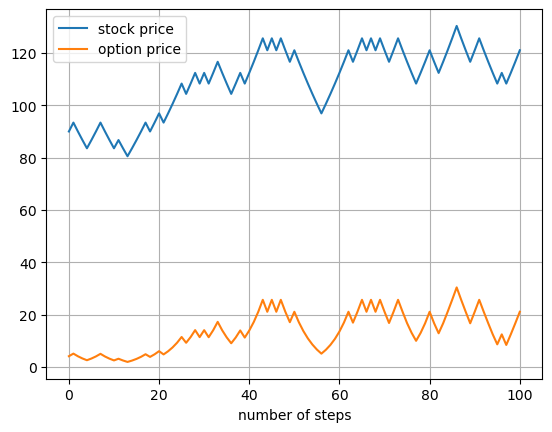

In [5]:
plt.plot(sim1['Stock Value'].index, sim1['Stock Value'].values, label='stock price')
plt.plot(sim1['Option Price'].index, sim1['Option Price'].values, label='option price')
plt.xlabel('number of steps')
plt.legend()
plt.grid(True)
plt.show()

From the graph we indeed check that the price of the call at maturity is indeed $C(T)=S(T)-K$.

## <font color='blue'> Continuous limit </font>

We now want to model the price of a stock $S(t)$ over time. We assume that it is described by a geometric Brownian motion

\begin{equation}
dS=\mu Sdt+\sigma Sdz\,,
\end{equation}

where $z=z(t)$ follows a standarised Wiener process and the constants $\mu$ and $\sigma$ are called the (percentage) drift and volatility respectively. Equivalently $\ln S$ follows a standard (arithmetic) Brownian motion

\begin{equation}
d(\ln S)=\nu dt+\sigma dz\,,\qquad\nu=\mu-\frac{1}{2}\sigma^{2}\,.
\end{equation}

where note that the change of variables here has to done using Ito's Lemma.

Let us now fix a time $T$ and divide it into $n$ equal steps each of duration $T/n$. For a large number of steps $n\gg T\nu^{2}/\sigma^{2}$ the behaviour of $S(t)$ can be well approximated by the binomial model discussed above. The 1-step parameters are given by

\begin{equation}
u_{s}=1/d_{s}=e^{\sigma\sqrt{T/n}}\,,\qquad p_{s}=\frac{1}{2}\big(1+\frac{\nu\sqrt{T/n}}{\sigma}\big)\,,
\end{equation}

with the initial stock price $S_0=S(t=0)$ and strike $K$.

We can now proceed to pricing the options. To simplify things, in this section we will consider no dividends $c=0$. Assuming that there is risk-free interest rate $r$ coninuously compounded, depositing cash on a money market account would grow at each step by a factor of

\begin{equation}
R_{s}=e^{rT/n}\,.
\end{equation}

With the function "step_parameters" below we can get the 1-step parameters if we are given the continuous time ones. The functions "BinomialLatticeCreation" and "BinomialSimulationCreation" are the continuous time analogues of "BinomialLattice" "BinomialSimulation" defined above respectively (note however that "BinomialLattice" is class not a function).

In [6]:
#Define the one-step parameters, valid only for no dividends c=0
def step_parameters(T, n_steps, r, nu, sigma):
    dt = T/n_steps
    u = np.exp(sigma*(np.sqrt(dt)))
    d = 1/u
    R = np.exp(r*dt)
    p = (1/2)*(1+nu*(np.sqrt(dt))/sigma)
    return {'u_step':u, 'd_step':d, 'R_step':R, 'p_step':p}

# Valid only for no dividends c=0
def BinomialLatticeCreation(n_steps, T, S0, r, nu, sigma, K, xi, american=False):
    u = step_parameters(T, n_steps, r, nu, sigma)['u_step']
    d = step_parameters(T, n_steps, r, nu, sigma)['d_step']
    R = step_parameters(T, n_steps, r, nu, sigma)['R_step']
    return BinomialLattice(n_steps, S0, u, d, R, 0, K, xi, american)

# Valid only for no dividends c=0
def BinomialSimulationCreation(n_steps, T, S0, r, nu, sigma, K, xi, american=False, seed=42):
    instance_lattice = BinomialLatticeCreation(n_steps, T, S0, r, nu, sigma, K, xi, american)
    p = step_parameters(T, n_steps, r, nu, sigma)['p_step']
    instance_random = random_walk_plus(n_steps, p, seed)
    instance_stocks = [instance_lattice.stock_prices[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    instance_options = [instance_lattice.option_prices[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    instance_exercise = [instance_lattice.exercise[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    return pd.DataFrame({'Stock Value': instance_stocks, 
                         'Option Price': instance_options, 
                         'Exercise?': instance_exercise})

The option price $C(S,t)$ at a given time $t$ and stock price $S$ at this time needs to satisfy the Black-Scholes equation (without dividends)

\begin{equation}
\frac{\partial C}{\partial t}+rS\frac{\partial C}{\partial S}+\frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2}C}{\partial S^{2}}=rC\,.
\end{equation}

To solve this equation we also need to specify boundary conditions for $C(S,T)$ For European calls these are given by $C_{S,T}=\max\big(S(T)-K,0\big)$. The relevant solution to the Black-Scholes equation is provided by the following expression

\begin{equation}
C(S,t)=S\Phi(d_{+})-Ke^{-r(T-t)}\Phi(d_{-})\,,\qquad\text{where}\qquad d_{\pm}=\frac{\ln(S/K)+(r\pm\sigma^{2}/2)(T-t)}{\sigma\sqrt{T-t}}\,
\end{equation}

and $\Phi(z)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{z}e^{-x^{2}/2}dx\,$ is the CDF of the normal distribution.

The "BS_european_call" function evaluates the above expression and "Simulation_BS_european_call" provides the relevant option values for a simulation.

In [7]:
def BS_european_call(t, S, K, T, r, sigma):
    if t<T:
        dt = T-t
        ln = np.log(S/K)
        dPlus = (ln+(r+(sigma**2)/2)*dt)/(sigma*(np.sqrt(dt)))
        dMinus = (ln+(r-(sigma**2)/2)*dt)/(sigma*(np.sqrt(dt)))
        price = S*(stats.norm.cdf(dPlus))-K*(np.exp(-r*dt))*(stats.norm.cdf(dMinus))
        return price
    elif t==T:
        return max(S-K,0)
    else:
        return 'After Expiration'

def Simulation_BS_european_call(n_steps, T, S0, r, nu, sigma, K, seed=42):
    instance_lattice = BinomialLatticeCreation(n_steps, T, S0, r, nu, sigma, K, 
                                               xi=1, american=False)
    p = step_parameters(T, n_steps, r, nu, sigma)['p_step']
    instance_random = random_walk_plus(n_steps, p, seed)
    instance_stocks = [instance_lattice.stock_prices[mm,instance_random[mm]] 
                       for mm in range(0,n_steps+1,1)]
    BS_options = [BS_european_call(mm*T/n_steps, instance_stocks[mm], K, T, r, sigma)
                         for mm in range(0,n_steps+1,1)]
    return pd.DataFrame({'BS Option Prices': BS_options})

Next, for a given simulation (stock prices common) we plot the option prices as those are derived from the recursive process we presented above and from the option prices derived from the Black_Scholes formula.

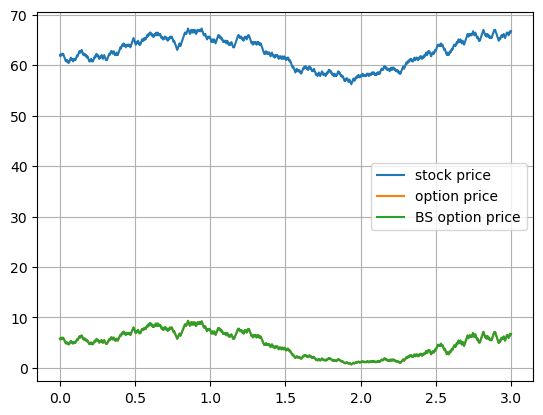

In [8]:
sim2 = BinomialSimulationCreation(n_steps=1000, T=5/12, S0=62, 
                                  r=0.1, nu=0.4, sigma=0.2, K=60, 
                                  xi=1, american=False, seed=52)
sim2_BS = Simulation_BS_european_call(n_steps=1000, T=5/12, S0=62, 
                                  r=0.1, nu=0.4, sigma=0.2, K=60, seed=52)

plt.plot(sim2['Stock Value'].index*(3/1000), sim2['Stock Value'].values, label='stock price')
plt.plot(sim2['Option Price'].index*(3/1000), sim2['Option Price'].values, label='option price')
plt.plot(sim2_BS['BS Option Prices'].index*(3/1000), sim2_BS['BS Option Prices'].values, label='BS option price')
plt.legend()
plt.grid(True)
plt.show()

The agreement between the two methods to evaluate the option prices is so good that we cannot distinguish the two lines. We can also check this by plotting their difference and see is always very close to zero (but not exactly zero).

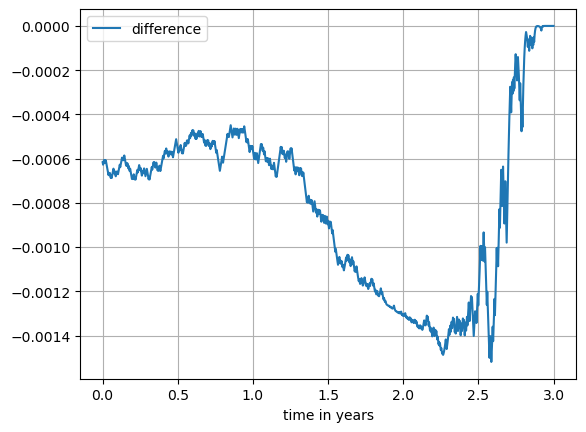

In [9]:
plt.plot((sim2['Option Price'].index)*(3/1000), 
         sim2['Option Price'].values-sim2_BS['BS Option Prices'].values, label='difference')
plt.xlabel('time in years')
plt.legend()
plt.grid(True)
plt.show()